# Mask and Social distancing Detection 

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import torch

### Using haar cascade to detect faces

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images. We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image.

In [3]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('harr/haarcascade_frontalface_default.xml')

(156, 400, 4)


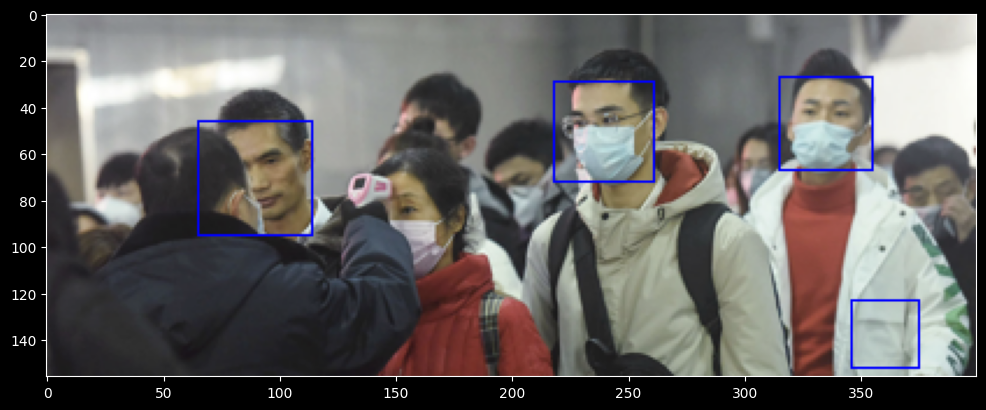

In [16]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('images/maksssksksss1.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.01, minNeighbors=4) #returns a list of (x,y,w,h) tuples
# scaleFactor: scale factor for each iteration of sliding window
# minNeighors: valid window

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)
print(img.shape)

100 100 100 100
(100, 100, 3)
(100, 100)
(100, 100, 3)
(100, 100)
(100, 100, 3)
(100, 100)
36 36 36 36
(36, 36, 3)
(36, 36)
(36, 36, 3)
(36, 36)
(36, 36, 3)
(36, 36)
25 25 25 25
(25, 25, 3)
(25, 25)
(25, 25, 3)
(25, 25)
(25, 25, 3)
(25, 25)
100 100 100 100
(100, 100, 3)
(100, 100)
(100, 100, 3)
(100, 100)
(100, 100, 3)
(100, 100)


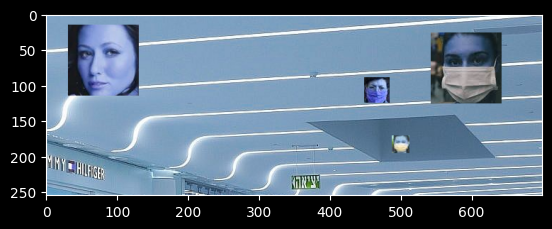

In [61]:
from random import randint
noise = cv2.imread('shopping.jpg',-1)
x_s = randint(0,noise.shape[1]-255)
y_s = randint(0,noise.shape[0]-255)
noise = noise[y_s:y_s+255,x_s:x_s+700]
plt.imshow(noise)
face_list = [cv2.imread('FaceMask_12k/Test/WithMask/153.png',-1),cv2.imread('FaceMask_12k/Test/WithMask/1163.png',-1),cv2.imread('FaceMask_12k/Test/WithMask/1362.png',-1),cv2.imread('FaceMask_12k/Test/WithoutMask/1014.png',-1)]
for s_face in face_list:
    x0 = randint(0,noise.shape[1])
    x1 = x0+s_face.shape[1]
    y0 = randint(0,noise.shape[0])
    y1 = y0+s_face.shape[0]
    print(y1-y0,x1-x0,s_face.shape[1],s_face.shape[0])
    for c in range(3):
        print(s_face.shape)
        print(noise[y0:y1,x0:x1,c].shape)
        noise[y0:y1,x0:x1,c]=s_face[:,:,c]
plt.imshow(noise)

### Using VGG19 for mask detection


In [11]:
#Load train and test set
train_dir = 'FaceMask_12k/Train'
test_dir = 'FaceMask_12k/Test'
val_dir = 'FaceMask_12k/Validation'

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms,path):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        # path in forms of 'FaceMask_12k/Test/'
        self.path = path
        pos_imgs = list(sorted(os.listdir(path+'WithMask')))
        neg_imgs = list(sorted(os.listdir(path+'WithoutMask')))
        self.imgs = []
        self.imgs.extend(pos_imgs)
        self.imgs.extend(neg_imgs)
        pos_label = torch.ones(len(pos_imgs))
        neg_label = torch.zeros(len(neg_imgs))
        self.label = torch.cat([pos_label,neg_label])
        
    def __getitem__(self, idx):
        img = Image.open(self.path+'/'+self.imgs[idx]).convert("RGB")
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

### Building VGG19 transfer learning model.

In [ ]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [ ]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

In [ ]:
model.evaluate_generator(test_generator)

Our modela achieved 98% accuracy on test data.

### Testing the model on the test data

In [ ]:
sample_mask_img = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [ ]:
model.predict(sample_mask_img)

The model is able to classify if the person is wearing a mask or not.

### Save the model.

In [ ]:
model.save('masknet.h5')

### Integrating with haar cascade

We now take crops of the faces detected in the image and use the model trained in the above section to determine whether the individual faces have a mask or not.

In [ ]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

In [ ]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

#### Red boxes shows violation of social distancing.